Code to simulate Fibre Bragg Grating  
Written by: Samhita S Sodhi (15/05/24)

This notebook contains code which loads spectral data of a particular gas and simulates Fibre Bragg Grating stretching/strain. The python script file "func.py" comprise of the functions that this notebook uses. 

Currently this notebook uses Nicholas' data from SAIL labs to test and write the functions. 

Notes from the author:
- Nicholas' acetylene data does not appear to be the same as the spectra produced by NASA PSG https://psg.gsfc.nasa.gov/
- Code is written such that all the data files need to be loaded in, eg. gas and fibre bragg grating 
- Code has been checked to work with NASA PSG data files and Nicholas' SAIL lab files -- may need to edit if data format is changed 
- Formula for Gaussian used: amp*1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)^2/(2*sigma^2)) source: https://www.geeksforgeeks.org/python-gaussian-fit/ , https://www.tutorialspoint.com/gaussian-fit-using-python, https://stackoverflow.com/questions/19206332/gaussian-fit-for-python
- Formula for Lorentzian used: (amp/np.pi) * (sigma/((x-mu)^2 + sigma^2)) source: https://lmfit.github.io/lmfit-py/builtin_models.html, https://scipython.com/book/chapter-8-scipy/examples/the-voigt-profile/
- The functions include: 
    - input_spectra: loads in the data, 
    - plot_spectra: simple plot of the data, 
    - fit_curves: fits a gaussian/lorentzian model to the datapoints, 
    - blackbodyabsorption: imprints a theoretical blackbody spectrum to data, 
    - apply_strain: simulates the stretching of fbg, 
    - plot_strainspectra: plots the output of simulate strain as a visualisation,
    - correlation: for several values of strain plots the amount of light transmitted/reflected,
    - convert_fluxunits_to_photoncounts: converts default flux units (erg / cm2 Hz s sr) to (photons/sec)

Issues
- Need to find appropriate lineshapes as lorentzian/gaussian don't fit data (example in scratch_SimulatingCode_FBG) -- voigt model would be more suitable using the equation provided on HITRAN https://hitran.org/docs/definitions-and-units/ or https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.voigt_profile.html. Three methods of doing Voigt fitting - either convolve a Gaussian and Lorentzian, find a Voigt function online or write an equation http://emilygraceripka.com/blog/16.
- The function which fits a Gaussian or Lorentzian to each peak uses a hardcoded "width value" which appears to work for the data I have worked with but needs to be looked into, there is a variable of 'widths' in find_peaks but does not appear to work
- I am unsure if the astropy.Blackbody model needs the wavelength units in Angstroms or not so my blackbody function converts the units
- It appears Nicholas wants to convert the default astropy.BlackBody outputs using the scale he provided {bb = BlackBody(temperature=temp*u.K, scale=1.0 * u.J / (u.cm ** 2 * u.nm * u.s * u.sr))} but I believe this is an incorrect approach since the function requires the scale to be equal to (erg / cm2 Hz s sr) which (J / cm2 nm s sr) isn't, so I use the default units (erg / cm2 Hz s sr).
- Function that simulates the straining of the fibre bragg grating carried a bug which showed overfitting at the boundary (particularly for shorter wavelengths), this is likely due to extrapolation overfitting values at the boundary since it only had data from one side, this was corrected using bound_error = 'false' https://docs.scipy.org/doc/scipy/tutorial/interpolate/extrapolation_examples.html, https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
- Theoretical modelling only uses blackbody -- improve by adding model for sunlight, whitelight, laser 
- The function which converts (erg / cm2 Hz s sr) to photon counts requires the wavelength and the transmitted values to have the same length but this causes the function 'correlation' to take a little longer than 1 hour to run which is not ideal and this will need to be looked into.
- When adding photon noise perhaps try Poisson noise rather than Gaussian noise as was used in Nicholas' code

In [1]:
import sys
sys.path.insert(0, ".")

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from astropy import units as u
from astropy import constants as const
from astropy.modeling.models import BlackBody
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from funcs import *

**Preparing the input spectral data**

Loading the datafile for the acetylene gas and plotting the spectra

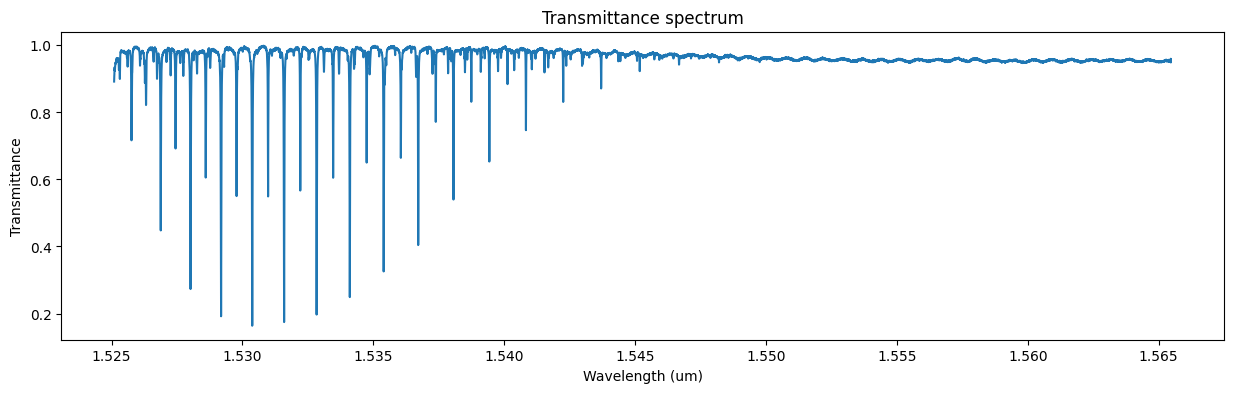

In [2]:
spectra_wav, spectra_data = input_spectra('/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/C2H2 gas cell-_40nm_1_T_C33-c2h2200C3M_42nm_0_T.txt', 0, 2, "\t", None, "nm", "dB")
plot_spectra(spectra_wav, spectra_data)

fit_curves used to fit lorentzian model to each of the peaks rather than having a plot with datapoints. Requires a detection_height variable such that values below this value i.e. 0.09 is not classified as a peak - can come in handy if the data is noisy.
blackbody_absorption fits a theoretical blackbody curve to the spectral data, requires a temperature in Kelvin to model

In [3]:
transmittance = fit_curves(spectra_wav, spectra_data, 0.09, 'lorentzian')
flux, transmitted_intensity = blackbodyabsorption(spectra_wav, transmittance, 3000)

**Loading fibre bragg grating data**

Loading in the spectral data for the fibre bragg grating - repeating the same steps

In [4]:
fibre_wavelength, fibregrating_line_data = input_spectra('/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/FBG_C33-c2h2200C3M_42nm_0_T.txt', 0, 2, '\t', None, "nm", "dB")
transmittanceFBG = fit_curves(fibre_wavelength, fibregrating_line_data, 0.09, 'lorentzian')
fluxFBG, transmitted_intensityFBG = blackbodyabsorption(fibre_wavelength, transmittanceFBG, 3000)

**Simulating stretching of the fibre bragg grating**

#testing the strain function as well as plotting; works well shows that not only is the fibre bragg grating being stretched but distances between the peaks are also changing

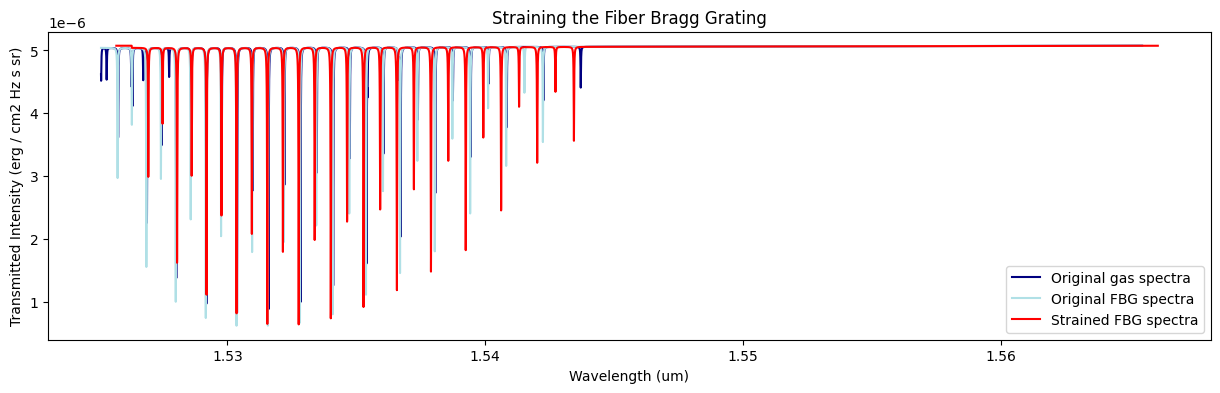

In [5]:
fibre_wavelength_new, interpolatedvals = apply_strain(0.0005, [spectra_wav, fibre_wavelength], [transmitted_intensity, transmitted_intensityFBG], 0, 0.55e-6, 8.6e-6, 0.22) #values for silica, no temperature change
plot_strainspectra([spectra_wav, fibre_wavelength, fibre_wavelength_new], [transmitted_intensity, transmitted_intensityFBG, interpolatedvals])

This cell is used to see the amount of light that is transmitted and reflected at different strain values. True values or normalised values can be computed

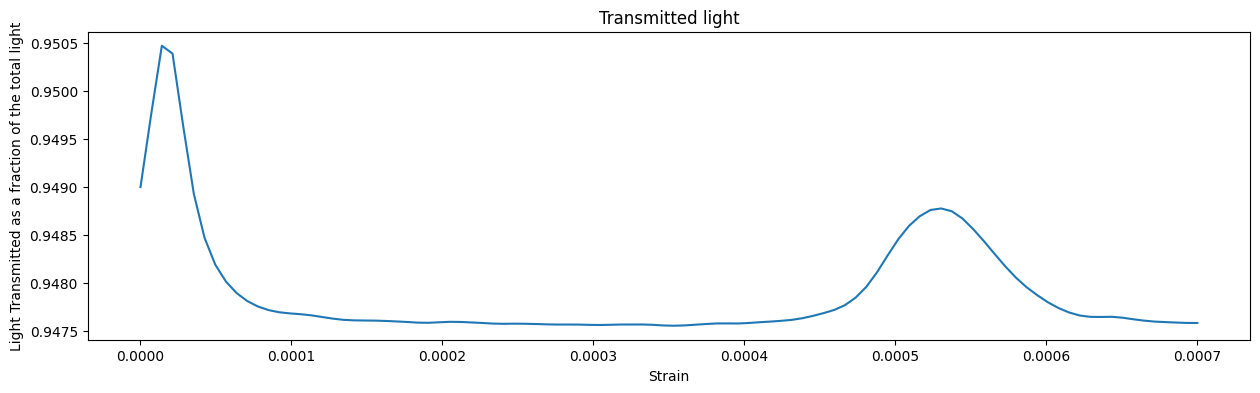

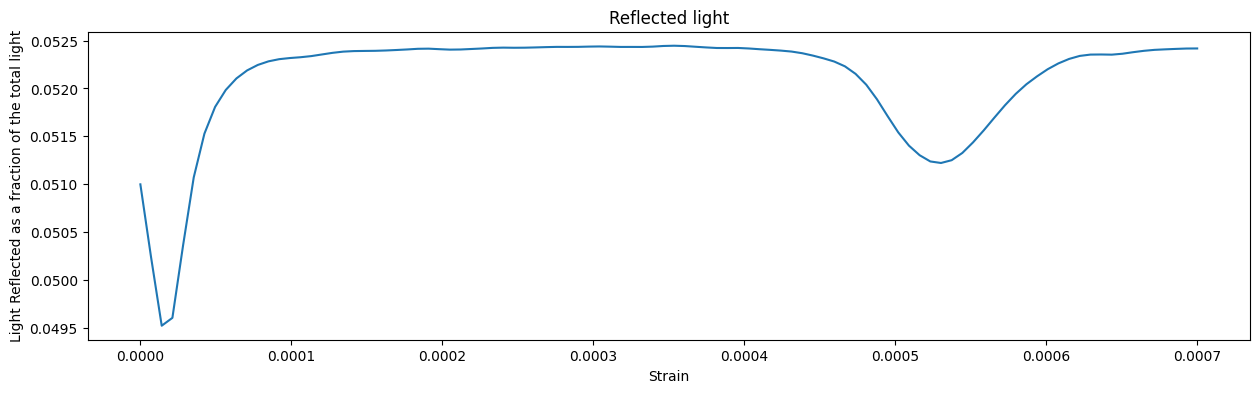

Total light (erg / cm2 Hz s sr): 1.0


In [6]:
### True values
# strain = np.linspace(0, 0.0007, 100) # takes a long time to run, else conversion to photoncounts does not work - wav, data different sizes! 
# transmittedlight, reflectedlight = correlation(strain, [spectra_wav, fibre_wavelength], spectra_data, [transmitted_intensity, transmitted_intensityFBG], 'False')


### Normalised values
strain = np.linspace(0, 0.0007, 100)
transmittedlightNorm, reflectedlightNorm = correlation(strain, [spectra_wav, fibre_wavelength], spectra_data, [transmitted_intensity, transmitted_intensityFBG], 'True')

**Converting units to photon counts**

This function can be used to convert units from erg / Hz cm2 s sr to photons per sec

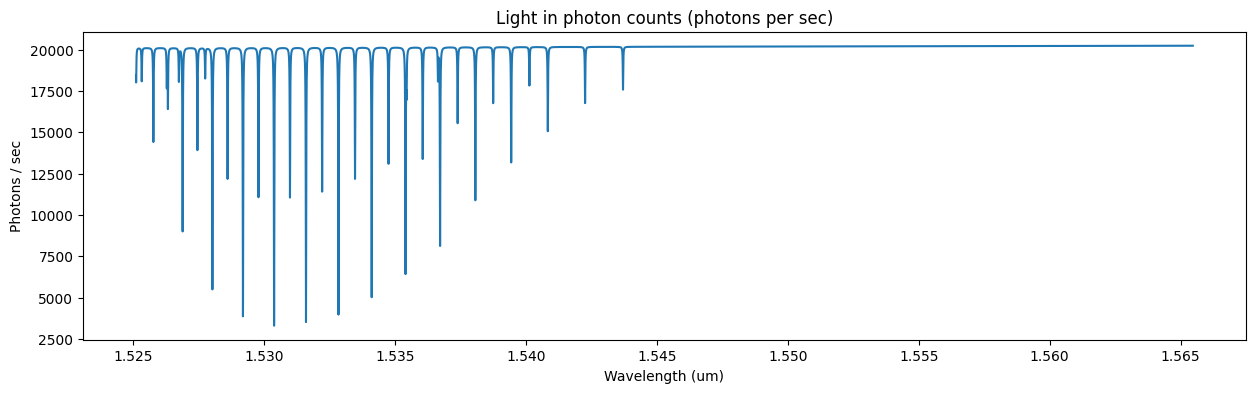

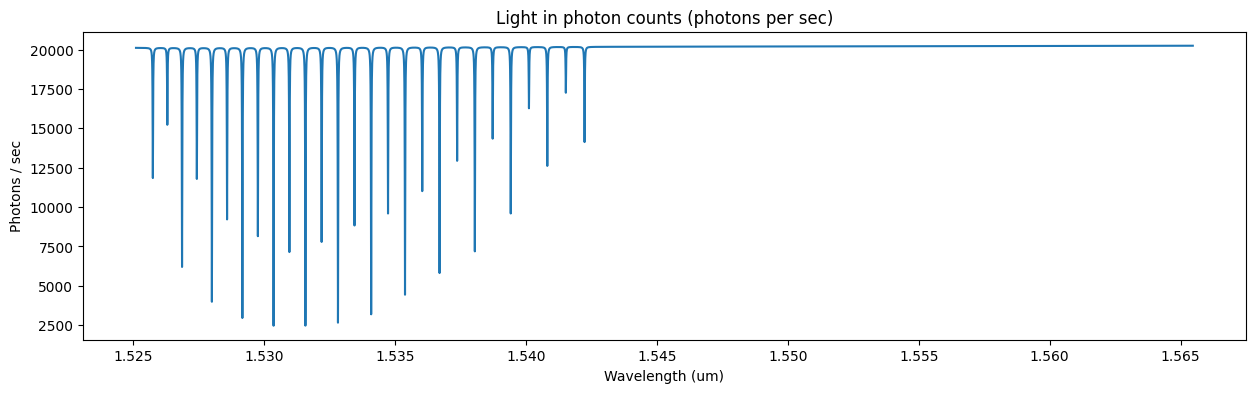

In [7]:
#testing unit conversion function
photoncount_persec = convert_fluxunits_to_photoncounts(spectra_wav, transmitted_intensity, 0.35, 0.000000503, 0.045, None, None)
photoncount_persec = convert_fluxunits_to_photoncounts(spectra_wav, transmitted_intensityFBG, 0.35, 0.000000503, 0.045, None, None)